Robot Dynamic Model Identification
=======
---

# 1 - Praparing work

## Import libraries

In [59]:
# enable auto-reload modules
%load_ext autoreload
%autoreload 2
#interactive plotting in separate window
%matplotlib qt 
#%matplotlib inline

from sympy import init_printing
init_printing()
    
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams.update({'font.size': 12})

import numpy as np
import sympy
from robot_def import RobotDef
from kinematics import Geometry
from dynamics import Dynamics
from trajectory_optimization import TrajOptimizer
from trajectory_optimization import TrajPlotter
from utils import new_sym
from utils import save_data, load_data
import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Folder dir for saving and loading files

In [2]:
#model_name = 'mtm_2spring_tendon'
model_name = 'mtm_fontanelli'

model_folder = 'data/' + model_name + '/model/'

---
# 2 - Robot modelling

## Robot geometry definition in following order

| Joint number | prev link | succ links | $a$ | $\alpha$ | $d$ | $\theta$ | link inertia | motor inertia | friction 

In [3]:
q0, q1, q2, q3, q4, q5, q6, q7, q8, q9, q10 = new_sym('q:11')
_pi = sympy.pi

# define paralelogram coordinate relation
# qd -> coordinate for dvrk_ros package
# qmd -> coordinate for the modeling joints
# q -> coordinate for motors
qd2 = q2
qd3 = -q2 + q3
qd4 = 0.6697*q2 - 0.6697*q3 + q4


qmd1 = q1
qmd2 = qd2
qmd30 = qd3
qmd31 = qd3 + qd2 
qmd32 = -qd3
qmd33 = q3
qmd4 = qd4
qmd5 = q5
qmd6 = q6
qmd7 = q7

# q31 = q3 + q2 
# q32 = -q3

l_b2p = 215.4 * 0.001
l_arm = 279.4 * 0.001
l_b2f = 100 * 0.001
l_fa = 364.5 * 0.001
h =105.6 * 0.001

# define link number
L_b = 0
L_1 = 1
L_2 = 2
L_30 = 3
L_31 = 4
L_32 = 5
L_4 = 6
L_5 = 7
L_6 = 8
L_7 = 9

# define spring delta L
dlN = None
dl1 = -qmd1
dl4 = -qmd4
dl5 = -qmd5
dl6 = -qmd6

# DH
# dh = [(L_b,  -1,   [L_1],       0,     0,      0,       0,           False, False, False, dlN),
#       (L_1,  L_b,  [L_2, L_31], 0,     0,      -l_b2p,  qmd1,        True,  False, True, dl1),
#       (L_2,  L_1,  [L_30],      0,     -_pi/2, 0,       qmd2+_pi/2,  True,  False, True, dlN),
#       (L_30, L_2,  [L_4],       l_arm, 0,      0,       qmd30+_pi/2, True,  False, True, dlN),
#       (L_31, L_1,  [L_32],      0,     -_pi/2, 0,       qmd31+_pi,   True,  False, True, dlN),
#       (L_32, L_31, [],          l_b2f, 0,      0,       qmd32-_pi/2, True,  False, True, dlN),
#       (L_4,  L_30, [L_5],       l_fa,  -_pi/2, 0.151,   qmd4,        True,  False, True, dl4),
#       (L_5,  L_4,  [L_6],       0,     _pi/2,  0,       qmd5,        True,  False, True, dl5),
#       (L_6,  L_5,  [L_7],       0,     -_pi/2, 0,       qmd6+_pi/2,  True,  False, True, dl6),
#       (L_7,  L_6,  [],          0,     -_pi/2, 0,       qmd7+_pi,    True,  False, True, dlN)]
dh = [(L_b,  -1,   [L_1],       0,     0,      0,       0,           False, False, False, dlN),
      (L_1,  L_b,  [L_2, L_31], 0,     0,      -l_b2p,  qmd1,        True,  False, True, dl1),
      (L_2,  L_1,  [L_30],      0,     -_pi/2, 0,       qmd2+_pi/2,  True,  False, True, dlN),
      (L_30, L_2,  [L_4],       l_arm, 0,      0,       qmd30+_pi/2, True,  False, True, dlN),
      (L_31, L_1,  [L_32],      0,     -_pi/2, 0,       qmd31+_pi,   True,  False, True, dlN),
      (L_32, L_31, [],          l_b2f, 0,      0,       qmd32-_pi/2, True,  False, True, dlN),
      (L_4,  L_30, [L_5],       l_fa,  -_pi/2, 0.151,   qmd4,        True,  False, True, dl4),
      (L_5,  L_4,  [L_6],       0,     _pi/2,  0,       qmd5,        True,  False, True, dl5),
      (L_6,  L_5,  [L_7],       0,     -_pi/2, 0,       qmd6+_pi/2,  True,  False, True, dl6),
      (L_7,  L_6,  [],          0,     -_pi/2, 0,       qmd7+_pi,    True,  False, True, dlN)]


# Friction
friction_type = ['Coulomb', 'viscous']
print(model_name)

robot_def = RobotDef(dh, dh_convention='mdh', friction_type=friction_type)

mtm_fontanelli


In [23]:
robot_def.dq_for_frame

In [24]:
robot_def.coordinates_joint_type

['R', 'R', 'R', 'R', 'R', 'R', 'R']

In [25]:
robot_def.bary_params

## Create kinematics chain

In [26]:
%time geom = Geometry(robot_def)

Frame: 0
Frame: 1
Frame: 2
Frame: 3
Frame: 4
Frame: 5
Frame: 6
Frame: 7
Frame: 8
Frame: 9
CPU times: user 56min 29s, sys: 7.16 s, total: 56min 36s
Wall time: 56min 27s


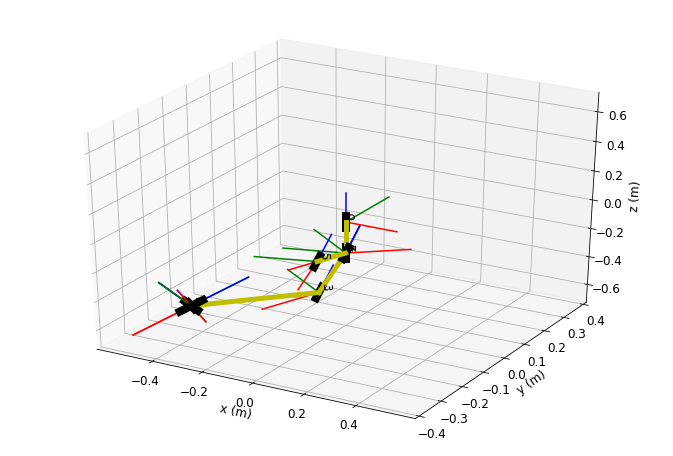

In [27]:
angle = [0.5, 0.3, -0.5, 0, 0, 0, 0]
geom.draw_geom(angle)

## Create dynamics

In [28]:
%time dyn = Dynamics(robot_def, geom)

Calculating Lagrangian...
Calculating the link kinetic energy of 1/9
Calculating the link kinetic energy of 2/9
Calculating the link kinetic energy of 3/9
Calculating the link kinetic energy of 4/9
Calculating the link kinetic energy of 5/9
Calculating the link kinetic energy of 6/9
Calculating the link kinetic energy of 7/9
Calculating the link kinetic energy of 8/9
Calculating the link kinetic energy of 9/9
Calculating joint torques...
tau of q1
tau of q2
tau of q3
tau of q4
tau of q5
tau of q6
tau of q7
Adding frictions and springs...
Add motor inertia...
Calculating regressor...
Calculating M, C and G...
Calculating base parameter...
base parameter number: 66
Creating H_b function...
Finished creating robot dynamics
CPU times: user 31min 24s, sys: 4.53 s, total: 31min 29s
Wall time: 31min 20s


In [29]:
robot_def.bary_params

In [30]:
sympy.Matrix(dyn.base_param)

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [31]:
from data import RobotModel

# Data to be saved
robot_model = RobotModel(dyn)

# Save
save_data(model_folder, model_name, robot_model)
print('Saved {} parameters'.format(len(robot_model.base_param)))

Saved 66 parameters


---
# 3 - Excitation trajectory optimization

In [10]:
model_name = 'mtm'

Load Data

In [11]:
from utils import load_data
model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder, model_name)

## Create trajectory optimizer object, with H matrix, foourier order, base frequency, joint constraints and cartisian constraints as input

In [12]:
#trajectory_name = 'one'
# trajectory_name = 'two'
trajectory_name = 'three'

In [13]:
from numpy import deg2rad

optimal_trajectory_folder = 'data/optimal_trajectory/'
trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'

base_freq = 0.1
fourier_order = 6

cartesian_constraints = []


joint_constraints = [(qmd1,  deg2rad(-57), deg2rad(29), deg2rad(-160), deg2rad(160)),
                     (qmd2,  deg2rad(-10), deg2rad(60), deg2rad(-180), deg2rad(180)),
                     (qmd30, deg2rad(-30), deg2rad(30), deg2rad(-180), deg2rad(180)),
                     (qmd4,  deg2rad(-40), deg2rad(195), deg2rad(-360), deg2rad(360)),
                     (qmd5,  deg2rad(-87), deg2rad(180), deg2rad(-360), deg2rad(360)),
                     (qmd6,  deg2rad(-40), deg2rad(38), deg2rad(-360), deg2rad(360)),
                     (qmd7,  deg2rad(-460), deg2rad(450), deg2rad(-720), deg2rad(720)),
                     (qmd31, deg2rad(-9), deg2rad(39), deg2rad(-360), deg2rad(360))]

    
traj_optimizer = TrajOptimizer(robot_model, fourier_order, base_freq,
                               joint_constraints=joint_constraints,
                               cartesian_constraints = cartesian_constraints)
                                                                                                 
                                                                                                                     
traj_optimizer.optimize()


joint constraint number: 8
cartesian constraint number: 0
constraint number: 32
frames_constrained: []
Condition number: 90.9681102027
Condition number: 90.9681090284
Condition number: 78.2257954513
Condition number: 52.2442858246
Condition number: 47.7568001076
Condition number: 52.3999783674
Condition number: 59.4557245605
Condition number: 69.3717483911
Condition number: 127.007508549
Condition number: 381.132708489
Condition number: 293.37927514
Condition number: 274.475499215
Condition number: 271.652179114
Condition number: 263.05927703
Condition number: 258.306014397
Condition number: 256.771012941
Condition number: 256.739417144
Condition number: 256.406138908
Condition number: 254.176811067
Condition number: 252.539061631
Condition number: 251.169946299
Condition number: 250.063250132
Condition number: 249.92688399
Condition number: 249.739872645
Condition number: 249.325158671
Condition number: 249.123159558
Condition number: 249.005872155
Condition number: 248.685794372
Cond

In [14]:
robot_model.coordinates

In [15]:
reg_norm_mat = traj_optimizer.calc_normalize_mat()

## Plot optimal excitation trajectory

In [16]:
traj_optimizer.calc_frame_traj()

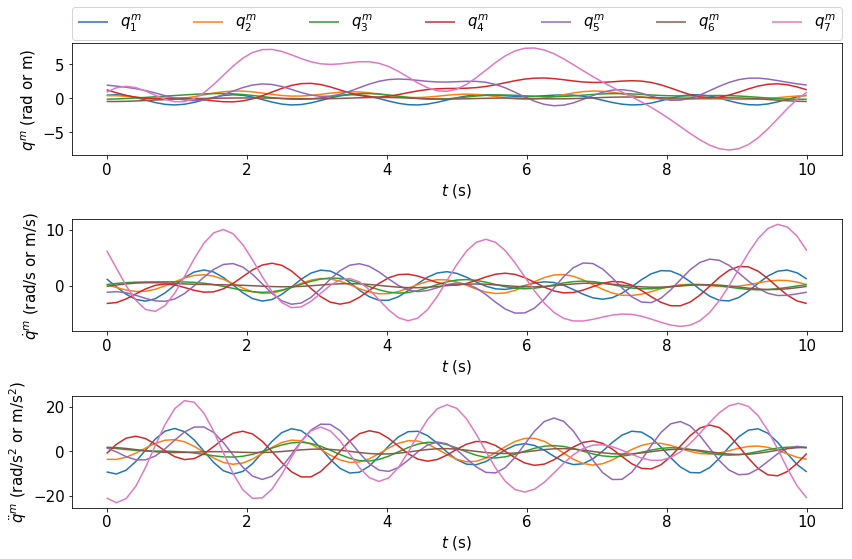

In [64]:
traj_plotter = TrajPlotter(traj_optimizer.fourier_traj,traj_optimizer.frame_traj,
                           traj_optimizer.const_frame_ind, robot_model.coordinates)
traj_plotter.plot_desired_traj(traj_optimizer.x_result)

# traj_plotter.plot_frame_traj(True)

## Save trajectory for later use

In [18]:
dof_order_bf_x_norm = (traj_optimizer.fourier_traj.dof, fourier_order,
                       base_freq, traj_optimizer.x_result, reg_norm_mat)
save_data(trajectory_folder, trajectory_name, dof_order_bf_x_norm)

In [19]:
from IPython.display import HTML, display
import tabulate

table = []
table.append(["joint", 'qo'] +
             ["a"+str(i+1) for i in range(fourier_order)] +
             ["b"+str(i+1) for i in range(fourier_order)])
for i in range(traj_optimizer.fourier_traj.dof):
    line = []
    line.append(robot_model.coordinates[i])
    line += np.round(traj_optimizer.x_result[i*(1 + fourier_order*2): (i+1)*(1 + fourier_order*2)], 4).tolist()
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

joint,qo,a1,a2,a3,a4,a5,a6,b1,b2,b3,b4,b5,b6
q1,-0.1671,-0.0558,0.1945,-0.3482,0.3881,-0.0943,1.0941,0.0806,-0.0737,-0.0835,0.4325,-0.8521,-2.0014
q2,0.3296,0.1238,0.1187,0.1056,-0.4766,-0.4632,0.7633,0.1054,0.255,-0.2133,-0.2537,0.1032,-0.8811
q3,0.2872,-0.038,0.0833,0.1957,-0.0284,-0.5618,0.5209,0.0203,0.1981,0.1434,0.4462,-0.0657,0.0539
q4,1.2372,-0.5113,0.171,-0.7172,0.1415,-0.4151,-1.8733,0.3747,0.2055,-1.1092,-1.0788,0.2916,0.6334
q5,1.2094,0.197,-0.9499,-0.3975,-1.3648,-0.6292,1.9457,0.0547,-1.0179,0.3421,-1.4488,-0.0689,1.5938
q6,-0.0573,-0.0241,-0.0513,0.0224,-0.0817,-0.1434,0.1289,0.0597,0.1632,0.1503,0.1452,0.027,0.2108
q7,1.7778,1.6753,3.2762,-0.9532,0.4475,0.5349,1.2668,2.2829,1.4583,-3.5573,-1.3535,-4.7746,0.1896


---
# Data processing

In [61]:
from identification import load_trajectory_data, diff_and_filt_data, plot_trajectory_data, plot_meas_pred_tau, plot_meas_2pred_tau, gen_regressor
import copy

ImportError: cannot import name plot_meas_2pred_tau

## Load data

### Load robot model

In [5]:
# Names as Arguments
model_name = 'mtm_fontanelli'
#model_name = 'mtm_2spring_tendon'
training_trajectory_name = 'one'


model_folder = 'data/' + model_name + '/model/'
robot_model = load_data(model_folder,model_name)


trajectory_folder = 'data/' + model_name +'/optimal_trajectory/'
dof, fourier_order, base_freq, traj_optimizer_result, reg_norm_mat = load_data(trajectory_folder,
                                                                               training_trajectory_name)
print("dof: {}".format(dof))
print("Fourier order: {}".format(fourier_order))
print("Base frequency: {}".format(base_freq))

dof: 7
Fourier order: 6
Base frequency: 0.1


### Load traning data set

In [6]:
# training_trajectory_name = 'one'

results_folder = 'data/' + model_name +'/measured_trajectory/'
training_results_data_file = results_folder + training_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_train, q_raw_train, dq_raw_train, tau_raw_train = load_trajectory_data(training_results_data_file,
                                                                   trajectory_sampling_rate)
# remove the cable part of the joint 4
# from high to low
p = np.array([0.0004877, -0.0037149, 0.0067497, 0.008519, -0.0201475, -0.025265, 0.048095, 0.00255])
#p = p[::-1]

# disable polynomial friction modeling
# qm4_raw_train = 0.6697*q_raw_train[:,1] - 0.6697*q_raw_train[:,2] + q_raw_train[:,3]
# tau_cable4_train = p[0]*qm4_raw_train**7 + p[1]*qm4_raw_train**6 + p[2]*qm4_raw_train**5\
# + p[3]*qm4_raw_train**4 + p[4]*qm4_raw_train**3 + p[5]*qm4_raw_train**2\
# + p[6]*qm4_raw_train + p[7]
# tau_raw_train[:,1] -= 0.6697*tau_cable4_train
# tau_raw_train[:,2] += 0.6697*tau_cable4_train
# tau_raw_train[:,3] -= tau_cable4_train

(<type 'numpy.ndarray'>, (5999, 21))


In [7]:
np.array([[1.0, 0, 0], [-1.0, 1.0, 0], [0.6697, -0.6697, 1.0]]).transpose()

array([[ 1.    , -1.    ,  0.6697],
       [ 0.    ,  1.    , -0.6697],
       [ 0.    ,  0.    ,  1.    ]])

### Training trajectory

In [8]:
from trajectory_optimization import FourierTraj
fourier_traj_train = FourierTraj(dof, fourier_order, base_freq, sample_num_per_period=20)
traj_plotter_train = TrajPlotter(fourier_traj_train, coordinates=robot_model.coordinates)
traj_plotter_train.plot_desired_traj(traj_optimizer_result)

### Load test data set

In [10]:
test_trajectory_name = 'two'

results_folder = 'data/' + model_name +'/measured_trajectory/'
test_results_data_file = results_folder + test_trajectory_name + '_results.csv'

trajectory_sampling_rate = 200
t_test, q_raw_test, dq_raw_test, tau_raw_test = load_trajectory_data(test_results_data_file,
                                                                trajectory_sampling_rate)
# remove the cable part of the joint 4
# from high to low
p = np.array([0.0004877, -0.0037149, 0.0067497, 0.008519, -0.0201475, -0.025265, 0.048095, 0.00255])
# p = p[::-1]

#disable polynomial friction modeling
# qm4_raw_test = 0.6697*q_raw_test[:,1] - 0.6697*q_raw_test[:,2] + q_raw_test[:,3]
# tau_cable4_test = p[0]*qm4_raw_test**7 + p[1]*qm4_raw_test**6 + p[2]*qm4_raw_test**5\
# + p[3]*qm4_raw_test**4 + p[4]*qm4_raw_test**3 + p[5]*qm4_raw_test**2\
# + p[6]*qm4_raw_test + p[7]
# tau_raw_test[:,1] -= 0.6697*tau_cable4_test
# tau_raw_test[:,2] += 0.6697*tau_cable4_test
# tau_raw_test[:,3] -= tau_cable4_test

# plt.plot(qm4_raw_test, tau_cable4_test)
# plt.xlabel('Time (s)')
# plt.ylabel('Joint torque (Nm)')

(<type 'numpy.ndarray'>, (5999, 21))


## Calculate filter cut-off frequency

In [11]:
# times of the highest frequency in the Fourier series

fc_mult = [3]
#fc_mult = [5, 5, 5, 3, 4, 4, 4]

#fc_mult = 4
fc = np.array(fc_mult)*base_freq* fourier_order 

print("Cut frequency: {}".format(fc))

Cut frequency: [1.8]


## Differentiation and filtering

### Traning data

In [12]:
cut_num = 200
t_cut_train, q_f_train, dq_f_train, ddq_f_train, tau_f_train, q_raw_cut_train, tau_raw_cut_train =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_train, q_raw_train, dq_raw_train, tau_raw_train, fc, fc, fc, fc, cut_num)
plot_trajectory_data(t_cut_train, q_raw_cut_train, q_f_train, dq_f_train, ddq_f_train,
                     tau_raw_cut_train, tau_f_train)

q_raw shape: (5999, 7)
plot shape: 470


### Test data

In [13]:
t_cut_test, q_f_test, dq_f_test, ddq_f_test,tau_f_test, q_raw_cut_test, tau_raw_cut_test =\
    diff_and_filt_data(dof, 1.0/trajectory_sampling_rate,
                       t_test, q_raw_test, dq_raw_test, tau_raw_test, fc, fc, fc, fc, cut_num)
plot_trajectory_data(t_cut_test, q_raw_cut_test, q_f_test, dq_f_test, ddq_f_test,
                     tau_raw_cut_test, tau_f_test)

q_raw shape: (5999, 7)
plot shape: 470


---
# Regression

## Ordinary Least Square (OLS)

### Generate regressor matrix for base parameters

In [14]:
base_param_num = robot_model.base_num
H_b_func = robot_model.H_b_func
W_b_train, tau_s_train = gen_regressor(base_param_num, H_b_func, q_f_train,
                                       dq_f_train, ddq_f_train, tau_f_train)

In [15]:
W_b_train.shape, tau_s_train.shape
#print np.linalg.cond(W_b_train)

In [16]:
xb_ols = np.linalg.lstsq(W_b_train, tau_s_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [17]:
#sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_ols))

from IPython.display import HTML, display
import tabulate

table = [["Base Parameter", "Value"]]

for i in range(robot_model.base_num):
    param_str = str(sympy.Matrix(robot_model.base_param)[i])
    max_disp_len = 50
    line = [param_str if len(param_str) <= max_disp_len 
            else param_str[:max_disp_len] + '...', xb_ols[i]]
    #['%.7s ...'%b if len(str(b)) > 7 else str(b)
    table.append(line)

display(HTML(tabulate.tabulate(table, tablefmt='html')))

Base Parameter,Value
1.0*L9xy,5.844136647811904e-05
1.0*L9xz,6.78551845886752e-05
1.0*L9yz,-1.4853632032201967e-05
1.0*L8yz,9.893430833028682e-05
1.0*L8xy,-0.0003313111338781099
1.0*L8xz,-0.0001919875016899537
1.0*L7xy,-0.00010915975266017263
1.0*L8xx - 1.0*L8yy + 1.0*L9yy,0.0010006615150471318
1.0*L9zz,0.00016025100325793486
1.0*L7xz,0.0004817356308339602


## Compare measured torque and predicted torque on the training set

### Generate predicted torque

In [18]:
tau_p_train = np.zeros(tau_f_train.shape)
tau_ps_train = W_b_train.dot(xb_ols)
for i in range(dof):
    tau_p_train[:, i] = tau_ps_train[i::dof]

# add cable torque back
# qm4_f_train = 0.6697*q_f_train[:,1] - 0.6697*q_f_train[:,2] + q_f_train[:,3]
# tau_cable4_f_train = p[0]*qm4_f_train**7 + p[1]*qm4_f_train**6 + p[2]*qm4_f_train**5\
# + p[3]*qm4_f_train**4 + p[4]*qm4_f_train**3 + p[5]*qm4_f_train**2\
# + p[6]*qm4_f_train + p[7]
tau_f_with_cable_train = copy.deepcopy(tau_f_train);
# tau_f_with_cable_train[:,1] = tau_f_train[:,1] + 0.6697*tau_cable4_f_train
# tau_f_with_cable_train[:,2] = tau_f_train[:,2] - 0.6697*tau_cable4_f_train
# tau_f_with_cable_train[:,3] = tau_f_train[:,3] + tau_cable4_f_train
tau_p_with_cable_train = copy.deepcopy(tau_p_train);
# tau_p_with_cable_train[:,1] = tau_p_train[:,1] + 0.6697*tau_cable4_f_train
# tau_p_with_cable_train[:,2] = tau_p_train[:,2] - 0.6697*tau_cable4_f_train
# tau_p_with_cable_train[:,3] = tau_p_train[:,3] + tau_cable4_f_train

### Evaluate regression

In [19]:
var_regression_error_ols = np.linalg.norm(tau_ps_train - tau_s_train) / \
                        (tau_ps_train.size - base_param_num)
print("variance of regression error using OLS:")
print(var_regression_error_ols)

std_dev_xb_ols = np.sqrt(np.diag(var_regression_error_ols *
                                 np.linalg.inv(W_b_train.transpose().dot(W_b_train))))
print("standard deviation of xb using OLS:")
print(std_dev_xb_ols)

pct_std_dev_xb_ols = std_dev_xb_ols / np.abs(xb_ols)
print("percentage of standard deviation of xb using OLS: ")
print(pct_std_dev_xb_ols)

variance of regression error using OLS:
0.00015743546121234497
standard deviation of xb using OLS:
[3.75239888e-06 2.24965125e-06 2.22331934e-06 1.71854555e-05
 1.60319036e-05 2.05884050e-05 1.98689121e-05 3.42780282e-05
 5.80516994e-06 1.66539016e-05 2.30476322e-05 7.89100658e-06
 3.42623830e-05 8.05135766e-06 4.96227365e-05 2.82956890e-05
 4.18092278e-05 5.09140278e-05 2.46419957e-05 1.23828230e-04
 3.58900596e-05 5.11132243e-05 3.82497109e-05 5.26402260e-05
 3.85212314e-05 6.10323641e-04 7.04235328e-04 1.68055008e-03
 5.19567075e-03 9.68111037e-05 6.11327625e-04 2.27832611e-04
 6.43911286e-04 6.02392203e-04 5.30944353e-04 1.33081321e-04
 1.33337668e-04 1.00821203e-04 2.69949971e-04 1.51776003e-04
 1.15271989e-04 8.17293288e-04 6.10258411e-04 1.70285886e-03
 7.01318878e-04 5.15791239e-05 1.25036537e-04 1.32773710e-03
 6.89560486e-04 5.30174149e-04 1.53190727e-04 1.91372194e-04
 4.90823323e-04 9.45001591e-04 4.74101672e-04 8.91630390e-04
 1.29915549e-03 2.55390867e-04 2.07517728e-04 5

### Plot measured torque and predicted torque

In [20]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_with_cable_train[:plot_data_num, :],
                   tau_p_with_cable_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on the test set

In [22]:
W_b_test, tau_s_test = gen_regressor(base_param_num, H_b_func, q_f_test,
                                       dq_f_test, ddq_f_test, tau_f_test)

In [23]:
tau_p_test = np.zeros(tau_f_test.shape)
tau_ps_test = W_b_test.dot(xb_ols)
for i in range(dof):
    tau_p_test[:, i] = tau_ps_test[i::dof]

    # add cable torque back
# qm4_f_test = 0.6697*q_f_test[:,1] - 0.6697*q_f_test[:,2] + q_f_test[:,3]
# tau_cable4_f_test = p[0]*qm4_f_test**7 + p[1]*qm4_f_test**6 + p[2]*qm4_f_test**5\
# + p[3]*qm4_f_test**4 + p[4]*qm4_f_test**3 + p[5]*qm4_f_test**2\
# + p[6]*qm4_f_test + p[7]
tau_f_with_cable_test = copy.deepcopy(tau_f_test);
# tau_f_with_cable_test[:,1] = tau_f_test[:,1] + 0.6697*tau_cable4_f_test
# tau_f_with_cable_test[:,2] = tau_f_test[:,2] - 0.6697*tau_cable4_f_test
# tau_f_with_cable_test[:,3] = tau_f_test[:,3] + tau_cable4_f_test
tau_p_with_cable_test = copy.deepcopy(tau_p_test);
# tau_p_with_cable_test[:,1] = tau_p_test[:,1] + 0.6697*tau_cable4_f_test
# tau_p_with_cable_test[:,2] = tau_p_test[:,2] - 0.6697*tau_cable4_f_test
# tau_p_with_cable_test[:,3] = tau_p_test[:,3] + tau_cable4_f_test

In [24]:
plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_test[:plot_data_num, :],
                   tau_p_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Weighted Least Square (WLS)

### Training data set

In [25]:
# weight = np.sqrt(np.linalg.norm(tau_f - tau_p, axis=0)/(tau_f.shape[0] - base_param_num))
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)

In [26]:
W_b_train.shape, tau_s_train.shape

In [27]:
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_train.shape[0]/weight.shape[0])

In [28]:
weights.shape

In [29]:
W_b_wls_train = np.multiply(W_b_train, np.asmatrix(weights).transpose())
tau_s_wls_train = np.multiply(tau_s_train, weights)

In [30]:
xb_wls = np.linalg.lstsq(W_b_wls_train, tau_s_wls_train)[0]

/home/yan/anaconda2/envs/dynamics/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


In [31]:
#np.set_printoptions(precision=2)
sympy.Matrix.hstack(sympy.Matrix(robot_model.base_param), sympy.Matrix(xb_wls))

⎡                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                                             
⎢                                                   

In [33]:
tau_p_wls_train = np.zeros(tau_f_train.shape)
tau_ps_wls_train = W_b_train.dot(xb_wls)
for i in range(dof):
    tau_p_wls_train[:, i] = tau_ps_wls_train[i::dof]
    
tau_p_wls_with_cable_train = copy.deepcopy(tau_p_wls_train);
# tau_p_wls_with_cable_train[:,1] = tau_p_wls_train[:,1] + 0.6697*tau_cable4_f_train
# tau_p_wls_with_cable_train[:,2] = tau_p_wls_train[:,2] - 0.6697*tau_cable4_f_train
# tau_p_wls_with_cable_train[:,3] = tau_p_wls_train[:,3] + tau_cable4_f_train

In [34]:
plot_meas_pred_tau(t_cut_train[:plot_data_num], tau_f_with_cable_train[:plot_data_num, :],
                   tau_p_wls_with_cable_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type, 
                   robot_model.coordinates)

In [35]:
np.linalg.norm(tau_f_with_cable_train[:plot_data_num, :] - tau_p_wls_with_cable_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_with_cable_train[:plot_data_num, :], axis=0)

array([0.11687483, 0.19484476, 0.18483873, 0.27381924, 0.50862795,
       0.28723848, 0.29564408])

### Test data set

In [37]:
weight = np.max(tau_f_test, axis=0) - np.min(tau_f_test, axis=0)
weight
weight[1] /= 1
weight[2] /= 1
weight[3] /= 1
weight
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_b_test.shape[0]/weight.shape[0])

W_b_wls_test = np.multiply(W_b_test, np.asmatrix(weights).transpose())
tau_s_wls_test = np.multiply(tau_s_test, weights)

tau_p_wls_test = np.zeros(tau_f_test.shape)
tau_ps_wls_test = W_b_test.dot(xb_wls)
for i in range(dof):
    tau_p_wls_test[:, i] = tau_ps_wls_test[i::dof]

# add cable torque back
# qm4_f_test = 0.6697*q_f_test[:,1] - 0.6697*q_f_test[:,2] + q_f_test[:,3]
# tau_cable4_f_test = p[0]*qm4_f_test**7 + p[1]*qm4_f_test**6 + p[2]*qm4_f_test**5\
# + p[3]*qm4_f_test**4 + p[4]*qm4_f_test**3 + p[5]*qm4_f_test**2\
# + p[6]*qm4_f_test + p[7]
# tau_f_with_cable_test = copy.deepcopy(tau_f_test);
# tau_f_with_cable_test[:,1] = tau_f_test[:,1] + 0.6697*tau_cable4_f_test
# tau_f_with_cable_test[:,2] = tau_f_test[:,2] - 0.6697*tau_cable4_f_test
# tau_f_with_cable_test[:,3] = tau_f_test[:,3] + tau_cable4_f_test
tau_p_wls_with_cable_test = copy.deepcopy(tau_p_wls_test);
# tau_p_wls_with_cable_test[:,1] = tau_p_wls_test[:,1] + 0.6697*tau_cable4_f_test
# tau_p_wls_with_cable_test[:,2] = tau_p_wls_test[:,2] - 0.6697*tau_cable4_f_test
# tau_p_wls_with_cable_test[:,3] = tau_p_wls_test[:,3] + tau_cable4_f_test

plot_meas_pred_tau(t_cut_test[:plot_data_num], tau_f_with_cable_test[:plot_data_num, :],
                   tau_p_wls_with_cable_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [38]:
np.linalg.norm(tau_f_with_cable_test[:plot_data_num, :] - tau_p_wls_with_cable_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.12949085, 0.15529172, 0.34341645, 0.32181876, 0.60237056,
       0.36330126, 0.36876098])

## Convex optimization

### Generate regressor matrix for barycentric parameters

In [39]:
from identification import SDPOpt

bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_train, tau_s_train = gen_regressor(bary_param_num, H_func,
                                     q_f_train, dq_f_train, ddq_f_train, tau_f_train)

In [40]:
weight = np.max(tau_f_train, axis=0) - np.min(tau_f_train, axis=0)
# repeat the weight to generate a large vecoter for all the data
weights = 1.0/np.tile(weight, W_train.shape[0]/weight.shape[0])
W_w_train = np.multiply(W_train, np.asmatrix(weights).transpose())
tau_w_s_train = np.multiply(tau_s_train, weights)

In [41]:
weight

array([2.70936727, 0.83087494, 1.26860941, 0.29147275, 0.09333127,
       0.09894924, 0.00623326])

| min mass | max mass | min $r_x$ | max $r_x$ | min $r_y$ | max $r_y$ | min $r_z$ | max $r_z$ | max $F_c$ | max $F_v$ | max $F_o$ |
|----------|----------|-----------|-----------|-----------|-----------|-----------|-----------|-----------|--------------|-----------|

In [42]:
sdp_constraints = [(2, 20, -0.1, 0.1, -0.1, 0.1, -0.1, 0.3, 0.2, 0.2, 0.2, 0, 10), #1
                  (1, 15, -0.1, 0.15, -0.05, 0.05, -0.05, 0.05, 0.2, 0.2, 0.3, 0, 0), #2
                  (0.5, 5, -0.0, 0.3, -0.03, 0.03, -0.03, 0.03, 0.2, 0.2, 0.2, 0, 0), # 3
                  (1, 10, -0.1, 0.1, -0.05, 0.05, -0.1, 0.1, 0.2, 0.2, 0.3, 0, 0), # 3'
                  (0.05, 2, 0.05, 0.2, -0.02, 0.02, 0.02, 0.1, 0.2, 0.2, 0.2, 0, 0), # 3''
                  (0.05, 2, -0.03, 0.03, -0.00, 0.12, -0.15, 0.0, 0.2, 0.2, 0.2, 0, 10), # 4
                  (0.05, 1, -0.02, 0.02, -0.1, 0.00, -0.1, 0.00, 0.2, 0.2, 0.2, 0, 10), # 5
                  (0.05, 0.5, -0.02, 0.02, 0, 0.1, -0.1, 0.00, 0.2, 0.2, 0.2, 0, 10), # 6
                  (0.02, 0.5, -0.01, 0.01, -0.01, 0.01, -0.00, 0.1, 0.2, 0.2, 0.2, 0, 0),]#7]

In [43]:
len(sdp_constraints)
robot_model.frame_num

In [44]:


sdp_opt_std = SDPOpt(W_w_train, tau_w_s_train, robot_model,
                     sdp_constraints)
# sdp_opt_std = SDPOpt(W, tau_s, robot_model, sdp_constraints)
%time sdp_opt_std.solve(10000)

Regressor shape: (39193, 112)
Regressand shape: (39193,)
Creating variables...
Creating optimization objective...
Creating constraints...
Solving problem...
----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 1719201, CG tol ~ 1/iter^(2.00)
eps = 1.00e-03, alpha = 1.50, max_iters = 10000, normalize = 1, scale = 1.00
Variables n = 113, constraints m = 39402
Cones:	linear vars: 117
	soc vars: 39195, soc blks: 1
	sd vars: 90, sd blks: 9
Setup time: 5.99e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf      -nan      -inf      -inf       inf  1.31e-01 

  9400| 2.80e-01  4.99e-04  1.51e-03  6.69e+00  6.72e+00  3.80e-14  6.34e+02 
  9500| 2.80e-01  5.98e-04  1.45e-03  6.76e+00  6.78e+00  3.81e-14  6.44e+02 
  9600| 2.80e-01  4.83e-04  1.38e-03  6.83e+00  6.85e+00  3.81e-14  6.54e+02 
  9700| 2.80e-01  5.67e-04  1.36e-03  6.90e+00  6.92e+00  1.14e-13  6.59e+02 
  9800| 2.80e-01  5.48e-04  1.37e-03  6.97e+00  6.99e+00  3.82e-14  6.64e+02 
  9900| 2.80e-01  4.96e-04  1.41e-03  7.03e+00  7.05e+00  3.82e-14  6.69e+02 
 10000| 2.80e-01  5.97e-04  1.46e-03  7.10e+00  7.12e+00  3.83e-14  6.73e+02 
----------------------------------------------------------------------------
Status: Solved/Inaccurate
Hit max_iters, solution may be inaccurate
Timing: Solve time: 6.73e+02s
	Lin-sys: avg # CG iterations: 24.53, avg solve time: 6.65e-02s
	Cones: avg projection time: 1.53e-04s
----------------------------------------------------------------------------
Error metrics:
dist(s, K) = 8.6101e-09, dist(y, K*) = 2.3019e-09, s'y/|s||y| = -1.3798e-11
|Ax + s 

## Compare measured torque and predicted torque on training set

### Generate predicted torque

In [45]:
tau_p_sdp_train = np.zeros(tau_f_train.shape)
tau_ps_sdp_train = W_train.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_train[:, i] = tau_ps_sdp_train[i::dof]

# disable polynomial cable torque
# add cable torque back
# qm4_f_train = 0.6697*q_f_train[:,1] - 0.6697*q_f_train[:,2] + q_f_train[:,3]
# tau_cable4_f_train = p[0]*qm4_f_train**7 + p[1]*qm4_f_train**6 + p[2]*qm4_f_train**5\
# + p[3]*qm4_f_train**4 + p[4]*qm4_f_train**3 + p[5]*qm4_f_train**2\
# + p[6]*qm4_f_train + p[7]
# tau_f_with_cable_train = copy.deepcopy(tau_f_train);
# tau_f_with_cable_train[:,1] = tau_f_train[:,1] + 0.6697*tau_cable4_f_train
# tau_f_with_cable_train[:,2] = tau_f_train[:,2] - 0.6697*tau_cable4_f_train
# tau_f_with_cable_train[:,3] = tau_f_train[:,3] + tau_cable4_f_train
tau_p_sdp_with_cable_train = copy.deepcopy(tau_p_sdp_train);
# tau_p_sdp_with_cable_train[:,1] = tau_p_sdp_train[:,1] + 0.6697*tau_cable4_f_train
# tau_p_sdp_with_cable_train[:,2] = tau_p_sdp_train[:,2] - 0.6697*tau_cable4_f_train
# tau_p_sdp_with_cable_train[:,3] = tau_p_sdp_train[:,3] + tau_cable4_f_train

In [46]:
np.linalg.norm(tau_f_with_cable_train[:plot_data_num, :] - tau_p_sdp_with_cable_train[:plot_data_num, :], axis=0)\
    / np.linalg.norm(tau_f_with_cable_train[:plot_data_num, :], axis=0)

array([0.13099819, 0.21834573, 0.23266792, 0.31401481, 0.49678029,
       0.29614103, 0.29587482])

### Plot measured torque and predicted torque

In [47]:
plot_data_num = int(1.0 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_train[:plot_data_num] - t_cut_train[0],
                   tau_f_with_cable_train[:plot_data_num, :],
                   tau_p_sdp_with_cable_train[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

## Compare measured torque and predicted torque on test set

In [48]:
bary_param_num = len(robot_model.bary_param)
H_func = robot_model.H_func
W_test, tau_s_test = gen_regressor(bary_param_num, H_func,
                                   q_f_test, dq_f_test, ddq_f_test, tau_f_test)

In [83]:
tau_p_sdp_test = np.zeros(tau_f_test.shape)
tau_ps_sdp_test = W_test.dot(sdp_opt_std.x_result)
for i in range(dof):
    tau_p_sdp_test[:, i] = tau_ps_sdp_test[i::dof]
    
# add cable torque back
# qm4_f_test = 0.6697*q_f_test[:,1] - 0.6697*q_f_test[:,2] + q_f_test[:,3]
# tau_cable4_f_test = p[0]*qm4_f_test**7 + p[1]*qm4_f_test**6 + p[2]*qm4_f_test**5\
# + p[3]*qm4_f_test**4 + p[4]*qm4_f_test**3 + p[5]*qm4_f_test**2\
# + p[6]*qm4_f_test + p[7]
tau_f_with_cable_test = copy.deepcopy(tau_f_test);
# tau_f_with_cable_test[:,1] = tau_f_test[:,1] + 0.6697*tau_cable4_f_test
# tau_f_with_cable_test[:,2] = tau_f_test[:,2] - 0.6697*tau_cable4_f_test
# tau_f_with_cable_test[:,3] = tau_f_test[:,3] + tau_cable4_f_test
tau_p_sdp_with_cable_test = copy.deepcopy(tau_p_sdp_test);
# tau_p_sdp_with_cable_test[:,1] = tau_p_sdp_test[:,1] + 0.6697*tau_cable4_f_test
# tau_p_sdp_with_cable_test[:,2] = tau_p_sdp_test[:,2] - 0.6697*tau_cable4_f_test
# tau_p_sdp_with_cable_test[:,3] = tau_p_sdp_test[:,3] + tau_cable4_f_test

plot_data_num = int(1 / base_freq * trajectory_sampling_rate)
plot_meas_pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_with_cable_test[:plot_data_num, :],
                   tau_p_sdp_with_cable_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)

In [82]:
test_plot_data_folder = 'data/' + model_name +'/test_plot_data_folder/'
test_plot_data = (t_cut_test[:plot_data_num] - t_cut_test[0],
                   tau_f_test[:plot_data_num, :],
                   tau_p_sdp_test[:plot_data_num, :],
                   robot_model.coordinates_joint_type,
                   robot_model.coordinates)
save_data(test_plot_data_folder, test_trajectory_name, test_plot_data)

In [51]:
np.linalg.norm(tau_f_test[:plot_data_num, :] - tau_p_sdp_test[:plot_data_num, :], axis=0)\
/ np.linalg.norm(tau_f_test[:plot_data_num, :], axis=0)

array([0.11503431, 0.18592568, 0.3995263 , 0.36182945, 0.6934144 ,
       0.31096307, 0.36986051])

### Compare results based on our modeling

In [113]:
# reload(identification)
# reload(identification.plot_meas_2pred_tau)
from identification.data_processing import plot_meas_2pred_tau

# from identification import plot_meas_2pred_tau
(t_cut_test_mtm, tau_f_test_mtm, tau_p_sdp_test_mtm, joint_type_mtm, coordinates_mtm)= \
    load_data('data/' + 'mtm' +'/test_plot_data_folder/', test_trajectory_name)

plot_meas_2pred_tau(t_cut_test[:plot_data_num] - t_cut_test[0],
                    tau_f_test[:plot_data_num, :],
                    tau_p_sdp_test[:plot_data_num, :],
                    tau_p_sdp_test_mtm,
                    robot_model.coordinates_joint_type,
                    robot_model.coordinates)

In [74]:
from identification import params_array2table
x_bary_round= np.around(sdp_opt_std.x_result, decimals=7)
bary_param_table = params_array2table(x_bary_round, robot_model, 'bary')
# sympy.Matrix.hstack(sympy.Matrix(robot_model.bary_param), sympy.Matrix(sdp_opt_std.x_result))
bary_param_table

⎡link     Lₓₓ        L_xy        L_xz        L_yy        L_yz        L_zz     
⎢                                                                             
⎢ 1    9.8416674     0.0         0.0      9.8416674      0.0        2.2e-6    
⎢                                                                             
⎢ 2    0.0183364   0.000621   0.0022639   0.0300482    0.005132   0.0150189   
⎢                                                                             
⎢ 3    0.0083767  0.0026589   0.0025635   0.0188209   -0.0008857  0.0116383   
⎢                                                                             
⎢ 4    0.0244545  -0.0007867  0.0192811   0.0443905   0.0005613   0.0198973   
⎢                                                                             
⎢ 5    0.0166861  -0.000361   -0.0065029  0.0207145   0.0039511   0.0088901   
⎢                                                                             
⎢ 6    0.0133038  -0.0005617  -0.0035948  0.0136383 

In [75]:
from identification import barycentric2standard_params

In [76]:
x_std = barycentric2standard_params(sdp_opt_std.x_result, robot_model)
s_round_std = np.round(np.array(x_std).astype(np.float), decimals=7)

In [77]:
std_param_table = params_array2table(s_round_std, robot_model, 'std')
#sympy.Matrix.hstack(sympy.Matrix(robot_model.std_param), sympy.Matrix(x_std))
std_param_table

⎡link     Iₓₓ         I_xy        I_xz        I_yy        I_yz        I_zz    
⎢                                                                             
⎢ 1    9.7538305      0.0         0.0      9.7538305      0.0        2.2e-6   
⎢                                                                             
⎢ 2    0.0145921   0.0015879   -0.0043562  0.0144276   0.0045965   0.0029862  
⎢                                                                             
⎢ 3    0.0070919    -1.12e-5    -9.54e-5   0.0071302   -0.0002432   -5.78e-5  
⎢                                                                             
⎢ 4    0.0056199    -1.02e-5    -7.61e-5    0.00566    -0.000193    -5.92e-5  
⎢                                                                             
⎢ 5    0.0150852    0.00164    -0.0045029   0.014915   0.0047515   0.0030897  
⎢                                                                             
⎢ 6    0.0111662   -0.0006578  -0.0031847  0.0115289

### Write identified dynamic parameters into a JSON file

In [141]:
Rs = [np.matrix(R.evalf(subs={q1: 0, q2: 0, q3: 0, q4: 0, q5: 0, q6: 0, q7: 0})).astype(np.float64)
      for R in robot_model.R[1:]]
x_std_base_frame = barycentric2standard_params(sdp_opt_std.x_result, robot_model, Rs)
x_round_std_base_frame = np.round(np.array(x_std_base_frame).astype(np.float), decimals=7)
std_param_base_frame_table = params_array2table(x_round_std_base_frame, robot_model, 'std')
std_param_base_frame_table

⎡link     Iₓₓ         I_xy       I_xz        I_yy        I_yz        I_zz     
⎢                                                                             
⎢ 1    9.7538305      0.0         0.0     9.7538305      0.0        2.2e-6    
⎢                                                                             
⎢ 2    0.0144276   -0.0045965  0.0015879  0.0029862   0.0043562   0.0145921   
⎢                                                                             
⎢ 3    0.0070919    9.54e-5     1.12e-5    -5.78e-5   -0.0002432  0.0071302   
⎢                                                                             
⎢ 4    0.0056199    7.61e-5     1.02e-5    -5.92e-5   -0.000193    0.00566    
⎢                                                                             
⎢ 5     0.014915   -0.0047515   0.00164   0.0030897   0.0045029   0.0150852   
⎢                                                                             
⎢ 6    0.0111662   -0.0006578  0.0031847  0.0115289 

In [142]:
from identification import *
param_folder = 'data/' + model_name +'/dynamic_params/'
std_param_name = 'params'
write_parameters2json(std_param_base_frame_table, param_folder, std_param_name)

Parameters have been written into [data/mtm_fontanelli/dynamic_params/params.json] successfully!
